# fit_optimal_CNN

Using keras tuner (and different optimisers) to build optimal convolutional neural network

--- 

- Having tested a baseline CNN (5 convolutional layers with dropout and 2 MaxPools and 2 hidden dense), we find reasonable predictions are made for galaxy spin. 
- Some tuning (by hand) has been done to find optimal starting learning rate is around 0.001 (anything higher than this and the loss blows up). Have implemented this with an ADAM optimiser (i.e. with its own form of _momentum_) and a reduction on plateau to a minimum of 0.0001 (although maybe push this lower).
- Baseline model was run for 25 epochs - we will aim to go for 35 for the final model after tuning.
- Tuning hyperparameters (i.e. number of nodes in each layer and dropout)

In [1]:
import keras
import tensorflow as tf
import kerastuner as kt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import model_selection
from scipy import stats
import IPython 

import sdss_model_evaluate
import sdss_model_constructors

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Loading in pre-processed data
- SDSS image data downscaled to (80, 80) in shape and normalised to RGB values (0-1).
- Using sklearn to split into training, validation and test datasets.

In [2]:
data_dir = '../../data/cleaned_datasets/'

x = np.load(data_dir + 'x.npy')
y = np.load(data_dir + 'y.npy')

In [3]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# creating training sample
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 1 - train_ratio)

# creating test and validation training samples.
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test, test_size = test_ratio / (test_ratio + validation_ratio)) 
y_train.shape, y_val.shape, y_test.shape

((4505,), (966,), (966,))

### Using data generator objects to automatically augment training images to increase sample size.

In [4]:
train_gen = ImageDataGenerator(rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 45)
                               zoom_range = 0.25, # zoom range between 0.75 and 1.25 original size
                               horizontal_flip = True,
                               vertical_flip = True,
                               width_shift_range=0.05, # shifting centre by up-to 5%
                               height_shift_range=0.05) # shifting centre by up-to 5%

train_gen.fit(X_train)

### Loading in tunable model (i.e. number of filters in each layer)

In [5]:
tuner = kt.Hyperband(sdss_model_constructors.build_tuning_CNN,
                     objective = 'val_loss', # model evaluation metric
                     max_epochs = 8, # The maximum number of epochs to train one model. 
                     factor = 3, # Reduction factor for the number of epochs and number of models for each bracket.
                     directory = './tuning',
                     project_name = 'filter_tuning') 

# Before running the hyperparameter search, define a callback to clear the training outputs 
# at the end of every training step.

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project ./tuning/filter_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./tuning/filter_tuning/tuner0.json


In [6]:
tuner.search(train_gen.flow(X_train, y_train), 
             epochs = 10, 
             validation_data = (X_val, y_val),
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

INFO:tensorflow:Oracle triggered exit


In [7]:
print(f"""The hyperparameter search is complete.
The optimal number of filters are {best_hps.get('filters_1'), best_hps.get('filters_2'), 
best_hps.get('filters_3'), best_hps.get('filters_4'), best_hps.get('filters_5')} respectively""")

The hyperparameter search is complete.
The optimal number of filters are (64, 96, 128, 192, 192) respectively


### Tuning summary
- Here we basically took a look to see if increasing the number of filters in a given layer would improve performance.
- Based on this, it definitely seems so.
- Running new model with these hyperparameters before considering changes to dropout etc.

### Fitting CNN for 10 epochs
- Baseline test of performance before full run.

**Update:** fitting for 10 epochs yields similar (albeit very slightly worse) performance in comparison to the baseline CNN (see `./fit_baseline_CNN`) which was run for 25 epochs.
- Now running for 35 epochs (callbacks to save model state every 5 epochs)

In [ ]:
model = tuner.hypermodel.build(best_hps)

# defining reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

# saving best model state

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='../final-model/saved-model-{epoch:02d}-{val_loss:.2f}.hdf5', 
                                                               monitor='val_loss', 
                                                               save_best_only=False, 
                                                               save_weights_only=False, 
                                                               mode='auto', 
                                                               save_freq='epoch', 
                                                               period=5)

# running model for 35 total epochs
history = model.fit(train_gen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val), 
                    callbacks = [reduce_lr, model_checkpoint_callback],
                    epochs=35)


Epoch 1/35
141/141 [==============================] - ETA: 0s - loss: 0.256 - ETA: 54s - loss: 2.13 - ETA: 1:18 - loss: 1.478 - ETA: 1:28 - loss: 1.155 - ETA: 1:32 - loss: 0.965 - ETA: 1:35 - loss: 0.818 - ETA: 1:37 - loss: 0.725 - ETA: 1:38 - loss: 0.648 - ETA: 1:42 - loss: 0.589 - ETA: 1:45 - loss: 0.539 - ETA: 1:46 - loss: 0.497 - ETA: 1:47 - loss: 0.464 - ETA: 1:47 - loss: 0.432 - ETA: 1:48 - loss: 0.405 - ETA: 1:48 - loss: 0.385 - ETA: 1:48 - loss: 0.366 - ETA: 1:48 - loss: 0.348 - ETA: 1:47 - loss: 0.332 - ETA: 1:46 - loss: 0.317 - ETA: 1:45 - loss: 0.306 - ETA: 1:45 - loss: 0.294 - ETA: 1:45 - loss: 0.284 - ETA: 1:45 - loss: 0.274 - ETA: 1:45 - loss: 0.264 - ETA: 1:44 - loss: 0.256 - ETA: 1:43 - loss: 0.248 - ETA: 1:42 - loss: 0.240 - ETA: 1:40 - loss: 0.233 - ETA: 1:39 - loss: 0.227 - ETA: 1:37 - loss: 0.221 - ETA: 1:36 - loss: 0.215 - ETA: 1:35 - loss: 0.210 - ETA: 1:34 - loss: 0.205 - ETA: 1:34 - loss: 0.200 - ETA: 1:33 - loss: 0.196 - ETA: 1:33 - loss: 0.192 - ETA: 1:32 - lo

### Plotting loss history for model convergence

(0, 0.1)

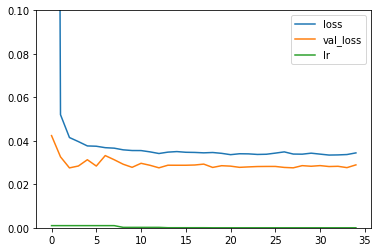

In [10]:
pd.DataFrame(history.history).plot()
plt.ylim([0, 0.1])

### Saving train, validation and test datasets to evaluate models in other scripts.
- Since I forgot to put a seed in the split here before running.